<center> <h2> Análisis del espectro de frecuencias de las olas que se generaron en el terremoto del 27 de febrero del 2010 usando los datos de la pagina web del <a href="https://ntwc.ncep.noaa.gov/previous.events/Chile_02-27-10/Tsunami-02-27-10.htm"> NationalTsunami Warning Center (NOAA/NWS)</a>, estación <a href="https://ntwc.ncep.noaa.gov/previous.events/Chile_02-27-10/Data/sped_B_2010.058">San Pedro 058</a> </h2> </center>

<p><b>Vamos a importar las librerias necesarias para el análisis</b></p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<p>Vamos a cargar la base de datos</p>

In [2]:
datos=np.loadtxt("Datos_SanPedro_058.txt")

In [3]:
altura=datos[:,1]
sampletime=datos[:,2]

<p>Debemos determinar la temporalidad de observación a partir del formato del tiempo de muestreo (yyyymmddhhmmdd). A partir de ahí, debemos establecer nuestro array de tiempo de observación, estableciendo que la primera medida en t=0min. A partir de ese punto, vamos a establecer el tiempo de observación en minutos. Para ello vamos a crear una función que reciba el array sampletime y devuelva el tiempo de observación en minutos</p>

In [4]:
def minutos(time):
    horas=np.array([(x // 10000) % 100 for x in time])
    minutos=np.array([(x // 100) % 100 for x in time])
    A=np.zeros(len(time))
    for i in range(0,len(time)):
        A[i]=horas[i]*60+minutos[i]-1
    return A
    
# Asignamos el array que contiene el tiempo de observación
tiempo=minutos(sampletime)

<p><b>1)</b> Realice un gráfico para la altura de las olas en función del tiempo, durante el periodo considerado. Utilice toda la información proporcionada por la estación, esto es, no excluya ninguna observación.</p>

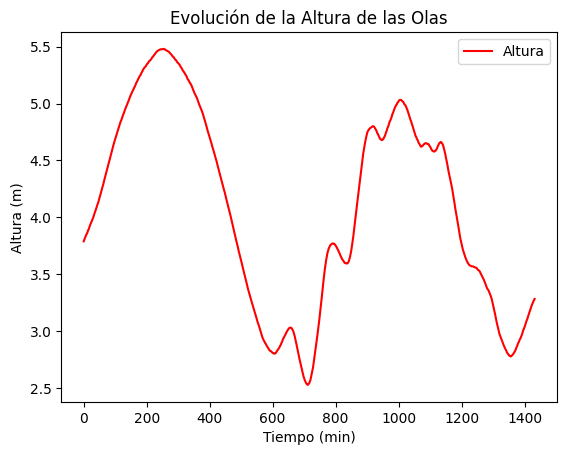

In [5]:
# Creamos el gráfico de líneas
plt.plot(tiempo,altura,label="Altura",color="red")
plt.xlabel("Tiempo (min)")
plt.ylabel("Altura (m)")
plt.title("Evolución de la Altura de las Olas")
plt.legend()
plt.show()

<p><b>2)</b> Realice un desarrollo truncado de la serie de Fourier, de modo de obtener un sistema de ecuaciones lineales para los coeficientes de Fourier.</p>

In [6]:
# Numero de observaciones
N=len(tiempo)
# Establecemos el periodo de observación
T=tiempo[N-1]-tiempo[0]
# Vamos a crear la función que permita construir matriz del sistema de ecuaciones
def sistema_ecuaciones(tiempo, periodo, numero_medidas):
    w=2*np.pi/periodo
    a=numero_medidas//2
    B=np.zeros((numero_medidas,numero_medidas))
    B[:,0]=0.5 #coeficientes a_0
    for n in range(1,a+1):
        B[:,2*n-1]=np.cos(n*w*tiempo) #coeficientes a_n
        B[:,2*n]=np.sin(n*w*tiempo) #coeficientes b_n
    return B

# asignamos la matris con el sistema de ecuaciones
A=sistema_ecuaciones(tiempo,T,N)

<p><b>3)</b> Invierta el sistema anterior para determinar el valor numérico de los coeficientes</p>

In [7]:
# calculamos la inversa de la matriz
A_inv=np.linalg.inv(A)
# calculamos los coeficientes de Fourier mediante X=(A^-1)(B)
coef_fourier=np.dot(A_inv,altura)

<p><b>4)</b> Considere la serie de Fourier generada por los primeros 11 coeficientes: a0 a1 a2 a3 a4 a5 b1 b2 b3 b4 y b5.
Gráfique la función generada por esta aproximación en función del tiempo, para 0 ≤ t ≤ T. Compare la aproximación con la onda original del punto</p>

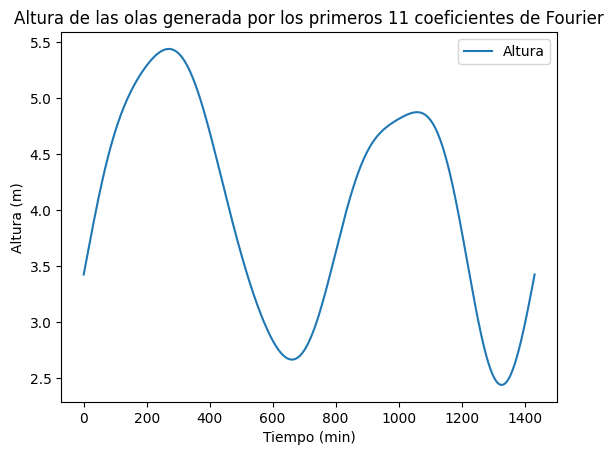

In [8]:
# vamos a crear una función que obtenga la serie de fourier de la función (aproximación de la alutra)
# para cualquier numero de coeficientes
def serie_fourier(tiempo,coeficientes,periodo,numero_coeficientes):
    N=numero_coeficientes//2
    w=2*np.pi/periodo
    a_0=coeficientes[0] #termino constante de la serie de Fourier
    suma=a_0/2
    for n in range(1,N+1):
        a=coeficientes[2*n-1] #coeficiente a_n
        b=coeficientes[2*n]   #coeficiente b_n
        suma+=a*np.cos(n*w*tiempo)+b*np.sin(n*w*tiempo)
    return suma

# serie de fourier con los primeros once termino
serie_once=serie_fourier(tiempo,coef_fourier,T,11)

# Graficamos la aproximación de la altura de las olas con los primeros once terminos
plt.plot(tiempo,serie_once,label="Altura")
plt.xlabel("Tiempo (min)")
plt.ylabel("Altura (m)")
plt.title("Altura de las olas generada por los primeros 11 coeficientes de Fourier")
plt.legend()
plt.show()

<p><b>5)</b> Grafique las amplitudes de todos los coeficientes de Fourier (obtenidos en el punto 3) en función de la frecuencia, es decir, obtenga el espectro de frecuencias del movimiento de las olas</p>

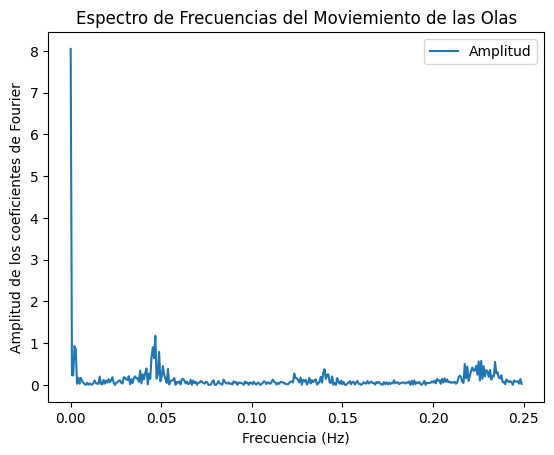

In [9]:
# intervalo de muestreo
inter_muestreo=(tiempo[len(tiempo)-1]-tiempo[0])/(len(tiempo)-1)
# frecuencias correspondientes
frecuencias=np.fft.fftfreq(len(tiempo),inter_muestreo)
amplitud=np.abs(coef_fourier) #amplitud de los coeficientes de fourier
#grafica del espectro de frecuencias de las olas
plt.plot(frecuencias[:N//2],amplitud[:N//2],label="Amplitud")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud de los coeficientes de Fourier")
plt.title("Espectro de Frecuencias del Moviemiento de las Olas")
plt.legend()
plt.show()
# Nota:La mitad de los datos es una opción común cuando trabajamos con la serie de Fourier
# porque los coeficientes correspondientes a las frecuencias negativas son los complejos
# conjugados de los coeficientes de las frecuencias positivas, es decir, produce un conjunto
# simétrico de coeficientes para frecuencias positivas y negativas y generalmente solo se necesita
# la mitad positiva para el análisis. Por lo tanto, podemos omitir la mitad de los coeficientes
# y aún así representar completamente el espectro de frecuencias.

<p><b>6)</b> Considere ahora la serie de Fourier generada por los primeros 11 coficientes más grandes (en valor absoluto) del punto (5)</p>

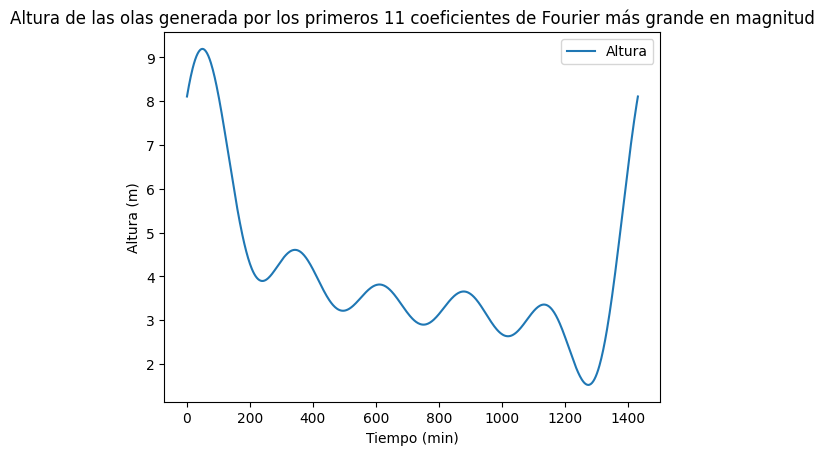

In [10]:
# reordenamos magnitud de mayor a menor
amplitud_ordenado=sorted(amplitud[:N//2],reverse=True)
# serie de fourier con los primeros once coeficientes mas grandes
serie_once_grande=serie_fourier(tiempo,amplitud_ordenado,T,11)
# Graficamos la aproximación de la altura de las olas con los primeros once terminos más grandes
plt.plot(tiempo,serie_once_grande,label="Altura")
plt.xlabel("Tiempo (min)")
plt.ylabel("Altura (m)")
plt.title("Altura de las olas generada por los primeros 11 coeficientes de Fourier más grande en magnitud")
plt.legend()
plt.show()

<p><b>7)</b>  Considere ahora la aproximación generada por los primeros 201 coeficientes (a0 a1 ..a200 b1 b2 ..b200)</p>

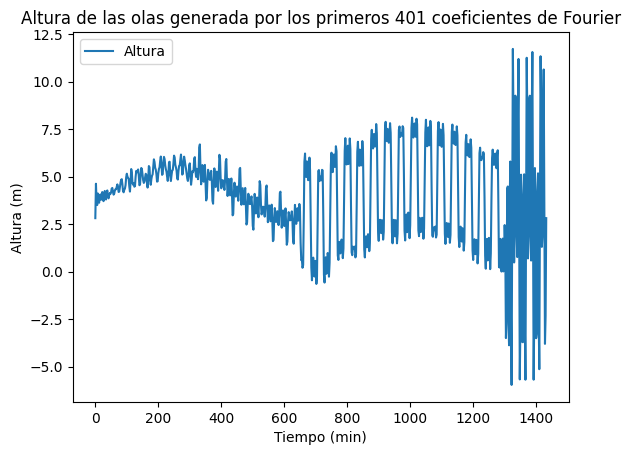

In [11]:
# altura aproximada generada por los primero 401 coeficientes
serie_401=serie_fourier(tiempo,coef_fourier,T,401)
# Gráfica de altura aproximada versus tiempo
plt.plot(tiempo,serie_401,label="Altura")
plt.xlabel("Tiempo (min)")
plt.ylabel("Altura (m)")
plt.title("Altura de las olas generada por los primeros 401 coeficientes de Fourier")
plt.legend()
plt.show()